In [2]:
# importing modules ("libraries")
from __future__ import division  # Not needed for Python 3.x
import matplotlib.pyplot as plt
import numpy as np
from numpy import log
from scipy.optimize import fminbound
from scipy import interp
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

# Value Function Iteration part 1


Today we are going to see Value Function Iteration.

This is an algorithm that solves for dynamic consumption problems - bellman equations. Roughly speaking, if you can write down your problem as a Bellman equation, you can solve it by VFI.

Of course there is a lot of small print to that. I won't go over it since it is very mathsy and I prefer to show you how it works. You can read it in this [quantecon lecture](https://lectures.quantecon.org/py/optgrowth.html), upon whom our exercise today is based.

I'll explain the basics with an example:

## A Deterministic Growth problem

The problem we want to solve is the following:

$$V(k) = \max_c u(c) + \beta V(k') $$
st
$$ c + k' = k^\alpha $$

Where $u(.)$ is our utility function, $c$ is consumption, $k$ is capital, $\alpha$ is a parameter of the production function and $\beta$ the discount rate. There is full depreciation. Variables next period are denoted with '

So how do we solve this? Well, we know that when we find the solution wue will be able to evaluate the right hand side of the bellman, obtaining a value for the *optimal* value function ($V^*$). In that case, it must be true that

$$V^*(k) = u(c^*) + \beta V^*(k') $$

So whatever decision we made about today it must be optimal for tomorrow too. Think about $V$ as a number for a second. We could start by setting $V_0=1$ (or any other number) and then calculate

$$\max_{k'} u(k^\alpha-k') + \beta V_0$$

Where I have substituted consumption from the budget/feasibility constraint. Call this value $V_1$, the value function that results from "guessing" $V_0$ is the answer. Of course, the most likely case is that $V_1\neq V_0$, so pur guess won't be the right answer.

But here comes the magic: if we repeat the process inserting $V_1$ as our new guess, and we keep repeating it, it will come to a point where $V_{n+1}= V_{n}$, so we would have found the optimal $V^*$ as we defined it above. If certain regulatity conditions are met - close, bounded space for $c$ and $V$, $u(.)$ is continous and concave etc. (I refer to you to the [quantecon lecture](https://lectures.quantecon.org/py/optgrowth.html) or any book on computational economics) then this algorithm is sure to converge. It is so powerful, it usually converges when we don't have a proof that it will - so we are not guaranteed to find an answer!

### Discretizing the space

However, you may ahve noticed that $V(k)$ is a function and I have been treating it like a number. There are different ways to deal with $V()$ and $c()$, but all of them require us to discretize the space somehow. The easiest and crudest way of doing it is to create a vector (grid) of possible capital stocks $k$, and let $max_{k'}$ mean "the best possible capital in the grid". This will give us a map $k\rightarrow k'$ (capital today to capital tomorrow) that would be our function.

Finally, let's set $u(c)=log(c)$. At this point you should know why :)

Let's see it in action!

In [3]:
# Defining Parameters (feel free to change)
alpha = 0.65
beta = 0.95

# Defining grid for capital
grid_max = 2
grid_size = 150
grid = np.linspace(1e-6, grid_max, grid_size) # you can plot it or print it to see it. It is good practice!

In this special case, we can get the solution with pen and pencil as you did in this course: the solution takes the form:

$$V^*(k) = \gamma_1 + \gamma_2 log(k) $$

where

$$\gamma_2= \frac{\alpha}{ (1-\alpha\beta)}$$
$$\gamma_1= \frac{log(1 - \alpha\beta) + log(\alpha\beta) * \frac{\alpha\beta}{(1 - \alpha\beta)}} {(1 - \beta)}$$

> **Task 1:** code the exact answer: define two variables for $\gamma_1$ and $\gamma_2$ and a function for the optimal value function.

In [6]:
# Exact solution (for comparison)
ab = alpha * beta   # This should help you
g1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
g2 = alpha / (1 - ab)

def v_star(k):
    return g1 + g2 * log(k)

## 2. The Bellman operator

Here is the code for *the bellman operator*, or the function that given a initial guess for the value function $w$ returns $Tw$, the next guess. It obtains the next guess by computing the optimal capital for all points of the capital grid, given value function for tomorrow $V(k')=w$. 

To calculate the optimal $a'$, it uses a function called [fminbound](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fminbound.html), which if you did the Christmas exercises you should be familiar with. Or at least know that is is an optimizer function similar ``fsolve`` in Matlab. For some technical reason, it is easier to find the minimun rather than the maximun.

Another function you want to check is [interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html), which interpolates a series of points $x = x_1,x_2,...$,$y = y_1,y_2,...$ as if it was "joining the dots" between them, thereby constructing a function $f(x)=y$. We will use it to generate the next guess: given an initial guess for the value function $V$ and a grid for capital $k$, it interpolates so to get $V(k)$. This way, we just need a series of values for V, not an entire function!

> **Task 2:** Read the code below, ask questions if you get lost, and make sure you udnerstand what it does. You can try out pieces of the code (say ```interp(x, xs, ys)```) in a separate cell to help you digest the code.

In [8]:
def bellman_operator(w):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function Tw on the grid points.

        * w is a flat NumPy array with len(w) = len(grid)

    The vector w represents the value of the input function on the grid
    points.
    """
    # For a set of w=v(k), link the points such that we get a function w(k)
    Aw = lambda x: interp(x, grid, w)
    
    # Generate our next guess:
    Tw = np.empty(grid_size)                                         # Create space for our new guess, w'
    for i, k in enumerate(grid):                                     # for each index and value of k in out grid: 
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)     # define the objective function (in one line)
        c_star = fminbound(objective, 1e-6, k**alpha)                # find the optimal c* that max. u(c) + beta w(k'(c))
        Tw[i] = - objective(c_star)                                  # store the values for our v(c*) => w'

    return Tw                                                        # Return those values as our new w'

Let's try the function!

> **Task 3**: Call the bellman operator function, then plor the result and the initial guess provided below.

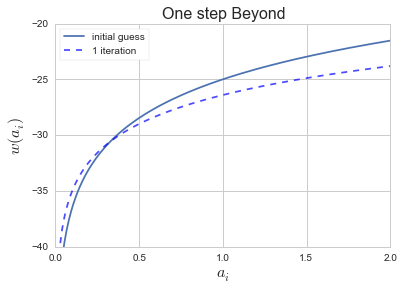

In [9]:
# Roll the bellman operator once
w0 = 5 * log(grid) - 25 # initial guess
w1 = bellman_operator(w0)

# Plot
plt.plot(grid,w0, label='initial guess')
plt.plot(grid,w1, c='blue', alpha=0.7, ls='--', label='1 iteration')
plt.ylabel('$w(a_i)$', fontsize=16)
plt.xlabel('$a_i$', fontsize=16)
plt.title('One step Beyond', fontsize=16)
plt.ylim(-40, -20)
plt.legend(loc='best', frameon=True)
plt.show()

Let's keep rolling! The resulting plot shows the convergence of the value function to the true one.

> **Task 4:** Fill in the blanks below to produce a rainbow plot

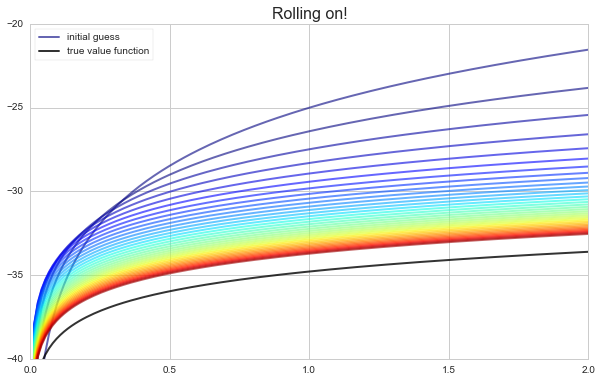

In [10]:
n = 35       # number of steps

# Plot configuration
plt.figure(figsize=(10,6))
plt.ylim(-40, -20)
plt.xlim(np.min(grid), np.max(grid))
plt.plot(grid, w0, color=plt.cm.jet(0), lw=2, alpha=0.6, label='initial guess')

# Bellman
w = w0
for i in range(n):
    w = bellman_operator(w)
    plt.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

# True value function
plt.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label='true value function')

# Final touches
plt.legend(loc='upper left', frameon='True')
plt.title('Rolling on!', fontsize=16)
plt.show()

So to solve our problem, we just need to keep going until convergence. Because we are using an approximation (gridpoints are finite, the solution (a function) is infinite) it won't be the case that $V_{n+1}=V_n$, so we need to stablish a *close enough* parameter we cal *tolerance* (or ```tol```).

Execute the cell below to solve the problem. 

Make sure you read and understand the steps - you can make comments on the side to remember what each piece of code does.

In [11]:
# Keep on going until convergence

w = w0
tol = 1e-6
distance = np.abs(np.max(w0 - bellman_operator(w0)))
iterations = 0
while distance > tol:
    w_next = bellman_operator(w)
    distance = np.abs(np.max(w - w_next))
    w = w_next
    iterations += 1
    if iterations % 50 == 0:
        print ' after {} iterations, distance is {}'.format(iterations, distance)
print 'Done'

 after 50 iterations, distance is 0.33932649899
 after 100 iterations, distance is 0.0243243552155
 after 150 iterations, distance is 0.00173746680156
 after 200 iterations, distance is 0.000124172034759
 after 250 iterations, distance is 8.87930593763e-06
Done


Let's plot the result! 

Again, read and make sure you understand the code.

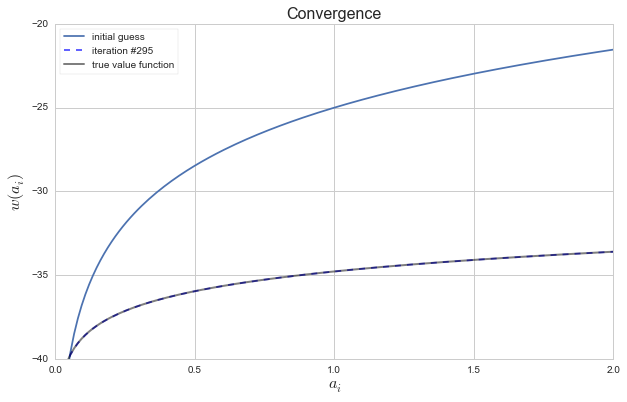

In [12]:
# plot the result
plt.figure(figsize=(10,6))

plt.plot(grid, w0, label='initial guess')
plt.plot(grid, w, c='blue', alpha=0.7, ls='--', label='iteration #{}'.format(iterations))
plt.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.5, label='true value function')

plt.ylim(-40, -20)
plt.ylabel('$w(a_i)$', fontsize=16)
plt.xlabel('$a_i$', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend(loc='best', frameon=True)
plt.show()

Great! We did it!

## 3. Solving for the optimal policy function

Just as we solved for $V$, it would be great if we could also know what is the optimal $c$ for each asset - so we can know the optimal savings.

To do that we just need to add a little tweek in the code.

> **Task 5** Read the code below. Can you find the differences with ```bellman_operator``` above?

In [15]:
def bellman_operator_plus(w, return_policy=False, grid=np.linspace(1e-6, 2, 150), u=lambda x: log(x)):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function Tw on the grid points.
    Inputs:
        * w is a flat NumPy array with len(w) = len(grid)
        * return_policy is a boolean, if true returns w (value) and c (optimal policy)
        * grid is a NumPy array with one-dimensional vector of state points
        * u is a function with a single numerical argument: instantaneous utility function

    Returns:
        * w  - and if return_policy==True, a tuple (w,c)
    """
    # For a set of w=v(a), link the points such that we get a function w(a)
    Aw = lambda x: interp(x, grid, w)
    
    # Generate our next guess:
    Tw = np.empty(grid_size)                                         # Create space for our new guess, w'
    policy = np.empty(grid_size)
    for i, k in enumerate(grid):                                     # for each index and value of k in out grid: 
        objective = lambda c: - u(c) - beta * Aw(k**alpha - c)     # define the objective function (in one line)
        c_star = fminbound(objective, 1e-6, k**alpha)                # find the optimal c* that max. u(c) + beta w(a'(c))
        Tw[i] = - objective(c_star)                                  # store the values for our v(c*) => w'
        policy[i] = c_star                                           # store the values for our c*
    # Return time
    if return_policy==False:
        return Tw                                                    # Return those values as our new w'
    else:
        return (Tw,policy)

Finally, let's run this function and solve the problem again

> **Task 6**: Fill in the blanks below - if you understood the function above it should be a pieve of cake!

In [16]:
w = w0
tol = 1e-6
distance = np.abs(np.max(w0 - bellman_operator(w0)))
iterations = 0
while distance > tol:
    bellman = bellman_operator_plus(w, return_policy=True,)
    w_next = bellman[0]
    policy = bellman[1]
    distance = np.abs(np.max(w - w_next))
    w = w_next
    iterations += 1
    if iterations % 50 == 0:
        print ' after {} iterations, distance is {}'.format(iterations, distance)
print 'Done'

 after 50 iterations, distance is 0.33932649899
 after 100 iterations, distance is 0.0243243552155
 after 150 iterations, distance is 0.00173746680156
 after 200 iterations, distance is 0.000124172034759
 after 250 iterations, distance is 8.87930593763e-06
Done


Finally, let's plot the solution

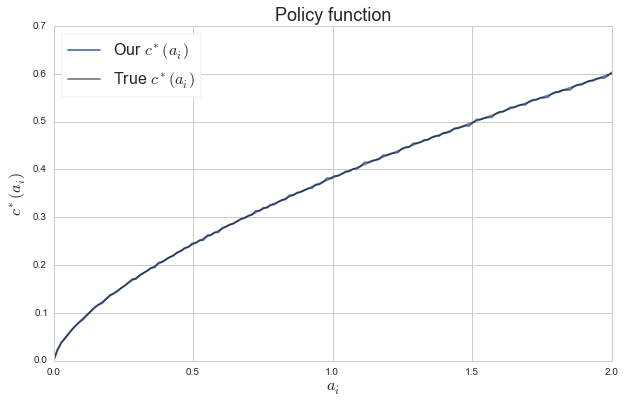

In [17]:
# Tru optimal consumption - from your notes. An evil macro teacher would tell you to find it yourself!
true_c = (1 - alpha * beta) * grid**alpha

# Plot
plt.figure(figsize=(10,6))
plt.plot(grid,policy, label='Our $c^*(a_i)$')
plt.plot(grid,true_c, color='black', alpha=0.5, label='True $c^*(a_i)$')
plt.title('Policy function', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.legend(loc='best',fontsize=16, frameon=True)
plt.show()

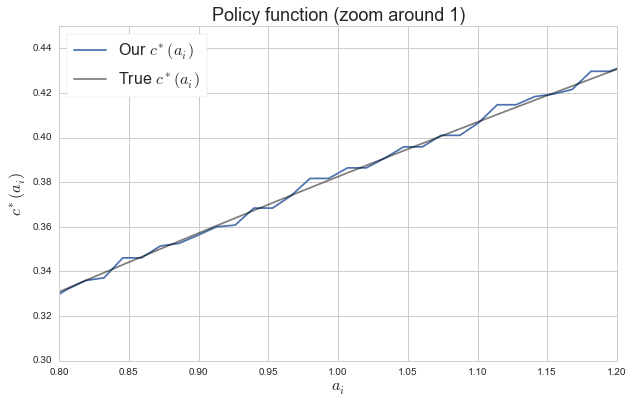

In [18]:
# Zoom in
plt.figure(figsize=(10,6))
plt.plot(grid,policy, label='Our $c^*(a_i)$')
plt.plot(grid,true_c, color='black', alpha=0.5, label='True $c^*(a_i)$')
plt.title('Policy function (zoom around 1)', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.xlim(0.8,1.2)
plt.ylim(0.3,0.45)
plt.legend(loc='best',fontsize=16, frameon=True)
plt.show()

## Finito

As you can see, the answer is just approximate - because of the discretization. There are more fancy ways of doing it, but I'll leave that for another time.

For now, you can play around with ```bellman_operator_plus```: try different utility functions, parameters, etc. It is nice to see the difference between logs, CRRA and quadratic utility for example.

Make sure you understand the logic of the algorithm. Next week we'll do something more interesting: a consumption/growth problem with uncertainty - first stochastic growth (white noise shocks) and then markow chain (the innovation tomorrow can be approximated from the innovation today).